In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
def get_vcf_df(vcf_fp, stop_on='#CHROM'):
    f = open(vcf_fp)

    line = ''
    header = ''
    while True:
        line = f.readline()
        if line[:6] == stop_on:
            break
            
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = line[1:].strip().replace('""', '').split('\t')
    df.index = df['ID']
    df.index.name = ''
    
    f.close()
    
    return df

In [3]:
def get_ancestry_map(map_fp):
    f = open(map_fp)
    
    # dump header
    f.readline()
    
    ancestry_map = {}
    for line in f:
        sample_id, ancestry = line.strip().split('\t')
        ancestry_map[sample_id] = ancestry
    
    return ancestry_map

In [4]:
def get_calls_matrix(vcf_fp):
    f_obj = open(vcf_fp)
    
    line = ''
    while True:
        line = f_obj.readline()
        if line[:6] == '#CHROM':
            break
    
    line = line.replace('\n', '')
    samples = line.split('\t')[SAMPLE_INDEX:]
    
    X = []
    for line in f_obj:
        line = line.replace('\n', '')
        pieces = line.split('\t')
        X.append(pieces[SAMPLE_INDEX:])
    
    return np.asarray(X), samples

In [5]:
# CALLED_VCF_FP = '/diskmnt/Projects/Users/estorrs/data/ancestry/MM/temp/called_samples.vcf'
# GENOMES_VCF_FP = '/diskmnt/Projects/Users/estorrs/1000-genomes/GRCh37/all.coding.sorted.02maf.10000sampled.sorted.snps.vcf'

In [6]:
# CALLED_VCF_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/vcf/called.vcf'
# # MM_CALLED_VCF_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MM/vcf/called.vcf'
# MM_CALLED_VCF_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MM/readcounts_2/grch37.combined.vcf'
# GENOMES_VCF_FP = '/gscmnt/gc2737/ding/estorrs/1000-genomes/GRCh37/all.coding.sorted.02maf.10000sampled.sorted.snps.vcf'
# PREDICTIONS_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/predictions/predictions.tsv'
# SELF_REPORTED_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/predictions/mmrf_self_reported.tsv'
# MM_PAPER_SAMPLES_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/predictions/MM_paper_patients.tsv'

In [7]:
genomes_vcf_fp = 'data/1000_genomes.vcf'
df = get_vcf_df(genomes_vcf_fp)

In [8]:
df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
,,,,,,,,,,,,,,,,,,,,,
rs1052751,17,4722785,rs1052751,G,A,.,PASS,AC=605;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
.,X,155254706,.,C,T,.,PASS,AC=392;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
rs2230862,6,56484758,rs2230862,C,T,.,PASS,AC=1685;AN=5008,GT,0|0,...,0|1,0|0,0|0,0|1,0|0,0|0,0|0,1|0,0|0,0|0
rs17279712,1,179877780,rs17279712,A,C,.,PASS,AC=189;AN=5008,GT,0|0,...,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
rs76321590,19,8182446,rs76321590,C,A,.,PASS,AC=184;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [9]:
ancestry_map_fp = 'data/ancestry_map.tsv'
sample_id_to_ancestry = get_ancestry_map(ancestry_map_fp)

list(sample_id_to_ancestry.items())[:5]

[('HG00096', 'EUR'),
 ('HG00097', 'EUR'),
 ('HG00099', 'EUR'),
 ('HG00100', 'EUR'),
 ('HG00101', 'EUR')]

In [10]:
set([ancestry for ancestry in sample_id_to_ancestry.values()])

{'AFR', 'AMR', 'EAS', 'EUR', 'SAS'}

## preprocessing

In [11]:
# remove X chromosome
df = df[df['CHROM'] != 'X']

df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
,,,,,,,,,,,,,,,,,,,,,
rs1052751,17,4722785,rs1052751,G,A,.,PASS,AC=605;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
rs2230862,6,56484758,rs2230862,C,T,.,PASS,AC=1685;AN=5008,GT,0|0,...,0|1,0|0,0|0,0|1,0|0,0|0,0|0,1|0,0|0,0|0
rs17279712,1,179877780,rs17279712,A,C,.,PASS,AC=189;AN=5008,GT,0|0,...,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
rs76321590,19,8182446,rs76321590,C,A,.,PASS,AC=184;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
rs3813050,17,39155969,rs3813050,A,G,.,PASS,AC=1493;AN=5008,GT,0|1,...,1|0,0|1,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0


In [12]:
# grab the columns we want
df = df[df.columns[9:]]

# transpose dataframe so samples are rows, mutations are columns
df = df.transpose()

sample_ids = list(df.index)

df.head()

,rs1052751,rs2230862,rs17279712,rs76321590,rs3813050,rs35039186,rs150393208,rs77400748,rs1468512,rs2288370,...,rs6591182,rs758773,rs117535467,rs10195,rs6062207,rs11253156,rs117893942,rs7247504,rs6006988,rs576619
HG00096,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,1|0,...,0|1,1|1,0|0,0|0,0|0,0|1,0|0,1|0,0|0,0|0
HG00097,0|1,1|1,0|0,0|0,1|0,0|0,0|0,0|0,0|1,0|0,...,1|1,0|0,0|0,0|0,0|0,1|1,0|0,1|0,0|0,0|0
HG00099,0|1,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,...,0|0,0|1,0|0,0|0,0|0,1|1,0|1,1|0,0|0,1|1
HG00100,1|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,1|0,0|0,0|0,0|0,0|0,1|1,0|0,0|1,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,0|1,0|0,0|0,0|0,1|0,0|0,0|1,0|0,0|0


In [13]:
df = df.replace(re.compile(r'^1\|0'), '0|1')

df.head()

,rs1052751,rs2230862,rs17279712,rs76321590,rs3813050,rs35039186,rs150393208,rs77400748,rs1468512,rs2288370,...,rs6591182,rs758773,rs117535467,rs10195,rs6062207,rs11253156,rs117893942,rs7247504,rs6006988,rs576619
HG00096,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|1,...,0|1,1|1,0|0,0|0,0|0,0|1,0|0,0|1,0|0,0|0
HG00097,0|1,1|1,0|0,0|0,0|1,0|0,0|0,0|0,0|1,0|0,...,1|1,0|0,0|0,0|0,0|0,1|1,0|0,0|1,0|0,0|0
HG00099,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,...,0|0,0|1,0|0,0|0,0|0,1|1,0|1,0|1,0|0,1|1
HG00100,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,0|0,0|0,0|0,0|0,1|1,0|0,0|1,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,0|1,0|0,0|0,0|0,0|1,0|0,0|1,0|0,0|0


In [14]:
# grab our target variable
ancestries = [sample_id_to_ancestry[sample_id] for sample_id in df.index]

target_df = pd.DataFrame.from_dict({
    'ancestry': ancestries
})
target_df.index = df.index

target_df.head()

,ancestry
HG00096,EUR
HG00097,EUR
HG00099,EUR
HG00100,EUR
HG00101,EUR


In [15]:
# split into training and test sets

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    df, target_df, test_size=0.2, random_state=123)

f'training set length: {X_train_df.shape[0]}', f'test set length: {X_test_df.shape[0]}'

('training set length: 2003', 'test set length: 501')

In [16]:
X_train_df.head()

,rs1052751,rs2230862,rs17279712,rs76321590,rs3813050,rs35039186,rs150393208,rs77400748,rs1468512,rs2288370,...,rs6591182,rs758773,rs117535467,rs10195,rs6062207,rs11253156,rs117893942,rs7247504,rs6006988,rs576619
NA12748,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|1,...,0|0,0|1,0|0,0|0,0|0,0|1,0|0,0|1,0|1,0|0
HG03681,0|0,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,1|1,0|0,0|0,0|0,0|0,1|1,0|0,1|1,1|1,0|0
NA19314,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|1,0|0,...,0|1,0|0,0|0,0|0,0|1,1|1,0|0,1|1,1|1,0|0
HG03741,0|0,0|0,0|0,0|0,0|1,0|1,0|0,0|0,0|0,0|1,...,1|1,0|0,0|0,0|0,0|0,0|1,0|0,0|0,1|1,0|0
HG01374,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,...,0|1,0|0,0|0,0|0,0|1,1|1,0|0,1|1,1|1,0|0


In [17]:
y_train_df.head()

,ancestry
NA12748,EUR
HG03681,SAS
NA19314,AFR
HG03741,SAS
HG01374,AMR


## training

In [18]:
X_train, X_test = X_train_df.values, X_test_df.values
y_train, y_test = y_train_df.values, y_test_df.values

In [19]:
X_train

array([['0|1', '0|0', '0|0', ..., '0|1', '0|1', '0|0'],
       ['0|0', '0|1', '0|1', ..., '1|1', '1|1', '0|0'],
       ['0|0', '0|0', '0|0', ..., '1|1', '1|1', '0|0'],
       ...,
       ['0|0', '0|1', '0|1', ..., '1|1', '1|1', '0|1'],
       ['0|0', '0|0', '0|0', ..., '1|1', '1|1', '0|0'],
       ['0|0', '0|1', '0|0', ..., '0|1', '0|1', '0|0']], dtype=object)

In [20]:
# encode genotype calls
genotype_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
genotype_encoder.fit(X_train)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False)

In [21]:
genotype_encoder.categories_[0]

array(['0|0', '0|1', '1|1'], dtype=object)

In [22]:
X_train = genotype_encoder.transform(X_train)

X_train

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [23]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, np.reshape(y_train, (y_train.shape[0],)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
clf.score(X_train, y_train)

1.0

In [25]:
X_test = genotype_encoder.transform(X_test)
clf.score(X_test, y_test)

0.9800399201596807

## Visualization

In [26]:
pca = PCA(n_components=20)
pca.fit(X_train)
X_train_principle_components = pca.transform(X_train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b338898>,
      dtype=object)

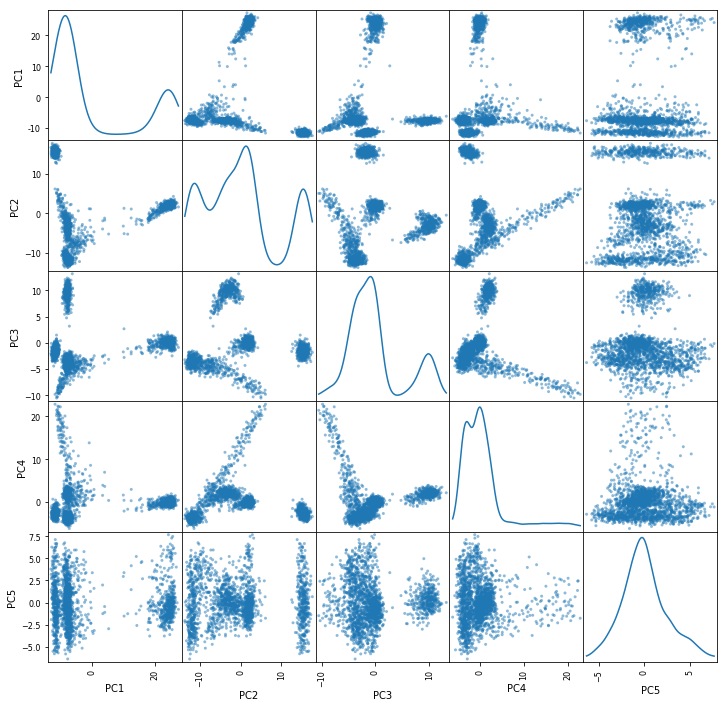

In [27]:
plotting_df = pd.DataFrame(data=X_train_principle_components[:, :5],
                          columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pd.plotting.scatter_matrix(plotting_df, figsize=(12,12), diagonal='kde')

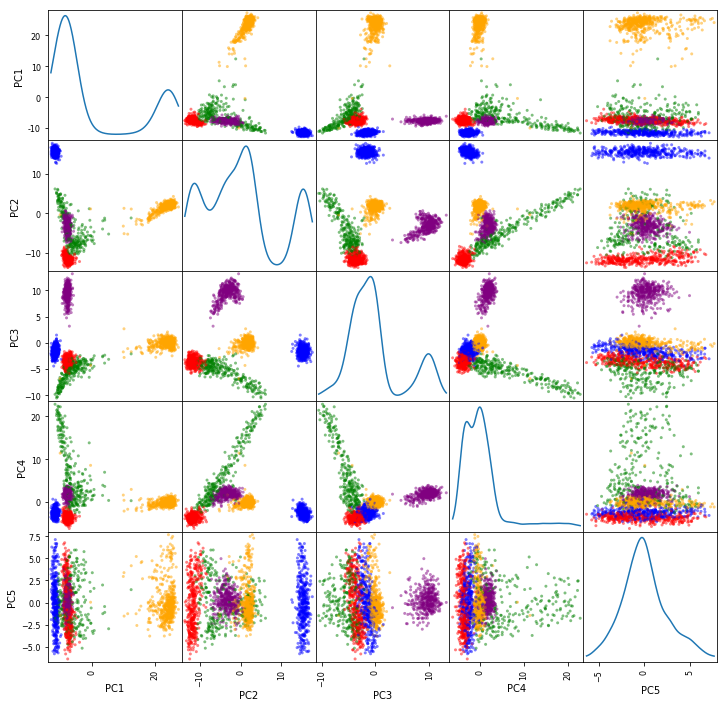

In [28]:
ancestry_to_color = {'EUR': 'red',
                     'EAS': 'blue',
                     'AMR': 'green',
                     'AFR': 'orange',
                     'SAS': 'purple'}
colors = [ancestry_to_color[sample_id_to_ancestry[s_id]]
          for s_id in X_train_df.index]

axs = pd.plotting.scatter_matrix(plotting_df, color=colors,
                           figsize=(12,12), diagonal='kde')

# fig = plt.figure()
# figlegend = plt.figure(figsize=(3,2))
# ax = fig.add_subplot(111)
# lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
# figlegend.legend(lines, ('one', 'two'), 'center')
# fig.show()
# figlegend.show()

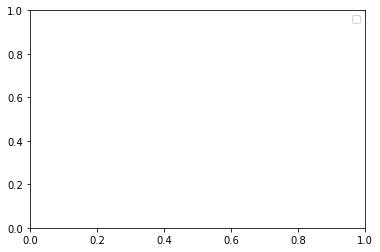

In [169]:
fig = pylab.figure()
figlegend = pylab.figure(figsize=(3,2))
ax = fig.add_subplot(111)
lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
figlegend.legend(lines, ('one', 'two'), 'center')
fig.show()
figlegend.show()

## Classifier 2

In [29]:
scaler = StandardScaler()
scaler.fit(X_train_principle_components)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [30]:
X_train_principle_components = scaler.transform(X_train_principle_components)

In [31]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_principle_components, np.reshape(y_train, (y_train.shape[0],)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
X_test_principle_components = pca.transform(X_test)

X_test_principle_components = scaler.transform(X_test_principle_components)

clf.score(X_test_principle_components, np.reshape(y_test, (y_test.shape[0],)))

0.9920159680638723

In [7]:
def get_preprocessed_X(df):    
    # remove x
    df = df[df['CHROM'] != 'X']
    df = df[df['CHROM'] != 'chrX']
    
    trimmed_df = df[df.columns[9:]]
    samples = trimmed_df.columns
    
    trimmed_df = trimmed_df.replace(re.compile(r'^0\|[1-9]+|^[1-9]+\|0'), '0|1')
    trimmed_df = trimmed_df.replace(re.compile(r'^[1-9]+\|[1-9]+'), '1|1')
    
    # encode genotype
    label_encoder = LabelEncoder()
    label_encoder.fit(['.|.', '0|0', '0|1', '1|1'])

    # encode the rows
    for i, row in trimmed_df.iterrows():
        trimmed_df.loc[i][:] = label_encoder.transform(row.values)
        
    X = trimmed_df.values

    # transpose so each row is now a sample
    X = X.transpose()
    
    return X, label_encoder, samples, trimmed_df
    

In [10]:
df_genomes, _ = get_headerless_vcf_df(open(GENOMES_VCF_FP))
df_called, _ = get_headerless_vcf_df(open(CALLED_VCF_FP))
df_called_MM, _ = get_headerless_vcf_df(open(MM_CALLED_VCF_FP))

In [11]:
df_genomes.shape, df_called.shape, df_called_MM.shape

((9531, 2513), (9531, 947), (9531, 32))

In [12]:
df_genomes.head(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,17,4722785,rs1052751,G,A,.,PASS,AC=605;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,X,155254706,.,C,T,.,PASS,AC=392;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,6,56484758,rs2230862,C,T,.,PASS,AC=1685;AN=5008,GT,0|0,...,0|1,0|0,0|0,0|1,0|0,0|0,0|0,1|0,0|0,0|0
3,1,179877780,rs17279712,A,C,.,PASS,AC=189;AN=5008,GT,0|0,...,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,19,8182446,rs76321590,C,A,.,PASS,AC=184;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [13]:
df_called_MM.head(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,25183.Relapse.grch37,...,59114.Post-Transplant.grch37,59114.Pre-Transplant.grch37,59114.Pre-Treatment.grch37,59114.Relapse-1.grch37,60359.Pre-Treatment.grch37,60359.Relapse.grch37,77570.Pre-Treatment.grch37,81012.Pre-Treatment.grch37,83942.Pre-Treatment.grch37,98433.Pre-Treatment.grch37
0,chr17,4722785,.,G,A,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|1,0|1,0|0,0|0,0|1,0|0
1,chrX,155254706,.,C,T,.,PASS,.,GT,0|0,...,0|1,0|1,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|1
2,chr6,56484758,.,C,T,.,PASS,.,GT,1|1,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0
3,chr1,179877780,.,A,C,.,PASS,.,GT,0|0,...,0|1,0|1,0|1,0|1,0|0,0|0,0|0,0|1,0|0,0|0
4,chr19,8182446,.,C,A,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [14]:
df_called.head(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,MMRF_1016_1,...,MMRF_2746_1,MMRF_2750_1,MMRF_2751_1,MMRF_2752_1,MMRF_2753_1,MMRF_2754_1,MMRF_2755_1,MMRF_2756_1,MMRF_2757_1,MMRF_2758_1
0,chr17,4722785,.,G,A,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,chrX,155254706,.,C,T,.,PASS,.,GT,.|.,...,0|0,.|.,.|.,.|.,0|0,.|.,.|.,.|.,.|.,0|0
2,chr6,56484758,.,C,T,.,PASS,.,GT,1|1,...,0|1,0|1,0|1,0|0,0|0,0|1,0|1,0|0,0|0,0|0
3,chr1,179877780,.,A,C,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,chr19,8182446,.,C,A,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [15]:
df_genomes.tail(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
9526,10,5437365,rs11253156,A,G,.,PASS,AC=3955;AN=5008,GT,0|1,...,1|1,0|1,1|1,1|1,1|1,1|1,1|0,1|1,1|1,1|1
9527,17,79213169,rs117893942,G,A,.,PASS,AC=157;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0
9528,19,4333711,rs7247504,C,T,.,PASS,AC=3283;AN=5008,GT,1|0,...,1|0,1|1,0|0,0|1,1|1,0|0,0|1,1|1,0|1,1|1
9529,22,45725106,rs6006988,T,C,.,PASS,AC=2651;AN=5008,GT,0|0,...,0|1,0|0,0|0,0|0,0|1,0|0,1|1,0|0,0|0,1|0
9530,4,169188780,rs576619,T,C,.,PASS,AC=406;AN=5008,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,0|0


In [16]:
df_called_MM.tail(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,25183.Relapse.grch37,...,59114.Post-Transplant.grch37,59114.Pre-Transplant.grch37,59114.Pre-Treatment.grch37,59114.Relapse-1.grch37,60359.Pre-Treatment.grch37,60359.Relapse.grch37,77570.Pre-Treatment.grch37,81012.Pre-Treatment.grch37,83942.Pre-Treatment.grch37,98433.Pre-Treatment.grch37
9526,chr10,5437365,.,A,G,.,PASS,.,GT,1|1,...,1|1,1|1,1|1,1|1,1|1,1|1,0|1,0|1,0|1,0|0
9527,chr17,79213169,.,G,A,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
9528,chr19,4333711,.,C,T,.,PASS,.,GT,0|1,...,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,1|1
9529,chr22,45725106,.,T,C,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|1,0|1,0|0,0|0,0|1,1|1
9530,chr4,169188780,.,T,C,.,PASS,.,GT,0|1,...,0|1,0|1,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0


In [17]:
# drop rows with all missing
to_drop = []
for i, row in df_called.iterrows():
    if len([x for x in list(row[9:]) if x != '.|.']) <= len(row[9:]) * .95:
        to_drop.append(i)
        
for i, row in df_called_MM.iterrows():
    if len([x for x in list(row[9:]) if x != '.|.']) <= len(row[9:]) * .95:
        to_drop.append(i)

df_genomes = df_genomes.drop(to_drop) 
df_called = df_called.drop(to_drop)
df_called_MM = df_called_MM.drop(to_drop)

In [18]:
df_genomes.shape, df_called.shape, df_called_MM.shape

((6645, 2513), (6645, 947), (6645, 32))

In [19]:
X_genomes_, encoder_genomes, samples_genomes, trimmed_df_genomes = get_preprocessed_X(df_genomes)

In [20]:
X_called_, encoder_called, samples_called, trimmed_df_called = get_preprocessed_X(df_called)

In [21]:
X_called_MM_, encoder_called_MM, samples_called_MM, trimmed_df_called_MM = get_preprocessed_X(df_called_MM)

In [22]:
# make copys so you dont have to rerun a bunch of times
X_genomes = np.copy(X_genomes_)
X_called = np.copy(X_called_)
X_called_MM = np.copy(X_called_MM_)

In [23]:
# impute missing values
imp_most_freq = SimpleImputer(missing_values=0, strategy='most_frequent')
X_genomes = imp_most_freq.fit_transform(X_genomes)
X_called = imp_most_freq.fit_transform(X_called)
X_called_MM = imp_most_freq.fit_transform(X_called_MM)

In [24]:
X_genomes.shape, X_called.shape, X_called_MM.shape

((2504, 6525), (938, 6525), (23, 6525))

In [25]:
np.all(df_genomes['POS'] == df_called['POS'])

True

In [26]:
pca_scaler = StandardScaler()
pca_scaler.fit(X_genomes)
X_genomes = pca_scaler.transform(X_genomes)

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
X_called = pca_scaler.transform(X_called)

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
X_called_MM = pca_scaler.transform(X_called_MM)

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# print(X_genomes.shape, X_called.shape)
# X = np.vstack((X_genomes, X_called))
# print(X.shape)

## PCA

In [22]:
# pca_scaler = StandardScaler()
# pca_scaler.fit(X)
# X = pca_scaler.transform(X)

In [23]:
# pca = PCA(n_components=20)
# pca.fit(X)
# pcs = pca.transform(X)

In [24]:
# pcs_df = pd.DataFrame(pcs)
# pd.scatter_matrix(pcs_df.loc[:, :3], figsize=(12,12))

In [29]:
pca = PCA(n_components=20)
pca.fit(X_genomes)
pcs_genomes = pca.transform(X_genomes)

In [137]:
pcs_genomes_df = pd.DataFrame(pcs_genomes)
pd.scatter_matrix(pcs_genomes_df.loc[:, :3], figsize=(12,12), diagonal='kde')

NameError: name 'pcs_genomes' is not defined

In [31]:
pcs_called = pca.transform(X_called)

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee245208d0>,
      dtype=object)

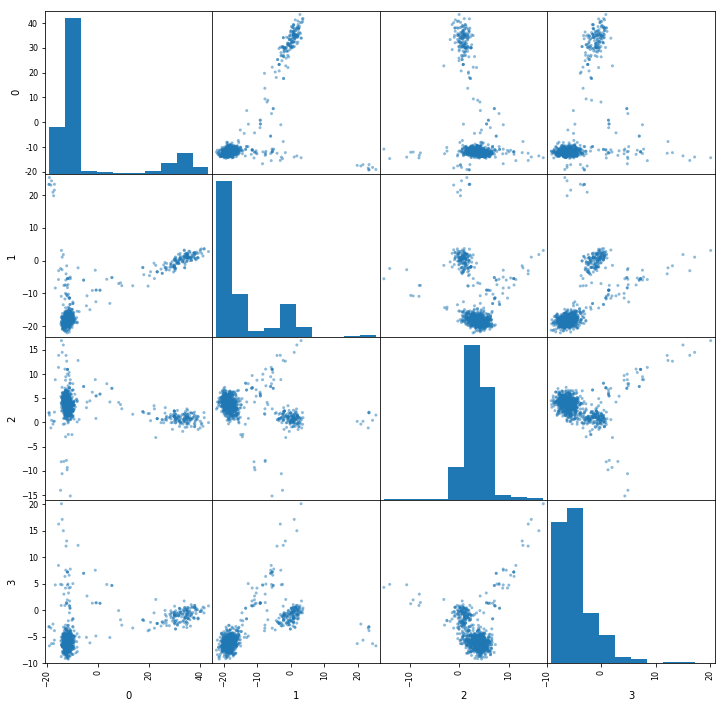

In [32]:
pcs_called_df = pd.DataFrame(pcs_called)
pd.scatter_matrix(pcs_called_df.loc[:, :3], figsize=(12,12))

In [33]:
pcs_called_MM = pca.transform(X_called_MM)

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee24fbae80>,
      dtype=object)

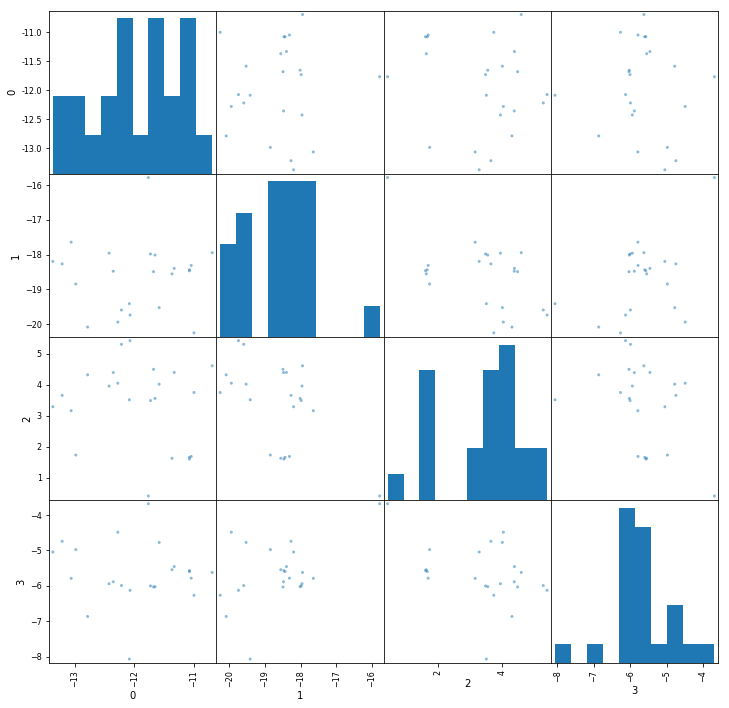

In [34]:
pcs_called_MM_df = pd.DataFrame(pcs_called_MM)
pd.scatter_matrix(pcs_called_MM_df.loc[:, :3], figsize=(12,12))

In [31]:
# component_df = pd.DataFrame(pca.components_,columns=trimmed_df_genomes.index)

In [32]:
# def get_most_informative_variants(df, variant_)

In [33]:
# idxs = np.argsort(np.asarray([abs(x) for x in pca.components_[0, :]]))
# [idxs[-10:]]

## annotate 1000 genomes

In [35]:
# load in 1000 genome labels
labels_df = pd.read_csv('/gscmnt/gc2737/ding/estorrs/1000-genomes/GRCh37/integrated_call_samples_v3.20130502.ALL.panel',
                       sep='\t')
labels_df.head()

,sample,pop,super_pop,gender,Unnamed: 4,Unnamed: 5
0,HG00096,GBR,EUR,male,NaN,NaN
1,HG00097,GBR,EUR,female,NaN,NaN
2,HG00099,GBR,EUR,female,NaN,NaN
3,HG00100,GBR,EUR,female,NaN,NaN
4,HG00101,GBR,EUR,male,NaN,NaN


In [36]:
# make sure order still matches
np.all(df_genomes.columns[9:] == labels_df['sample'])

True

In [37]:
sample_to_ancestry = {k:v for k, v in zip(labels_df['sample'], labels_df['super_pop'])}

ancestry_to_color = {'EUR': 'red', 'EAS': 'blue', 'AMR': 'green', 'AFR': 'orange', 'SAS': 'purple'}
colors = [ancestry_to_color[sample_to_ancestry[s]] for s in labels_df['sample']]

In [38]:
# ## extract back out into called and 1000 genomes
# pcs_genomes_df = pcs_df[:X_genomes.shape[0]][:]
# pcs_called_df = pcs_df[X_genomes.shape[0]:][:]
# pcs_genomes_df.shape, pcs_called_df.shape

In [39]:
def get_axis_limits(pcs_df, d=4):
    lims = []
    for i in range(d):
        c = pcs_df[i]
        lims.append((min(c), max(c)))
        
    return lims
        

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee212dd978>,
      dtype=object)

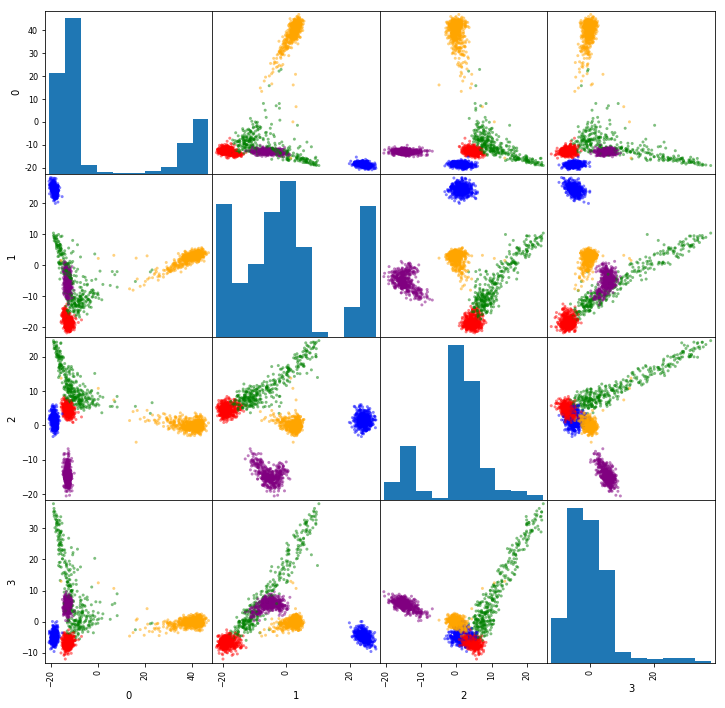

In [40]:
pd.scatter_matrix(pcs_genomes_df.loc[:, :3], color=colors, figsize=(12,12))

In [41]:
lims = get_axis_limits(pcs_genomes_df)
lims

[(-20.87176197061133, 46.785753515001865),
 (-21.91970528591056, 28.277617271246257),
 (-20.58288408703264, 24.6704716422723),
 (-12.035999254046724, 37.89723833908469)]

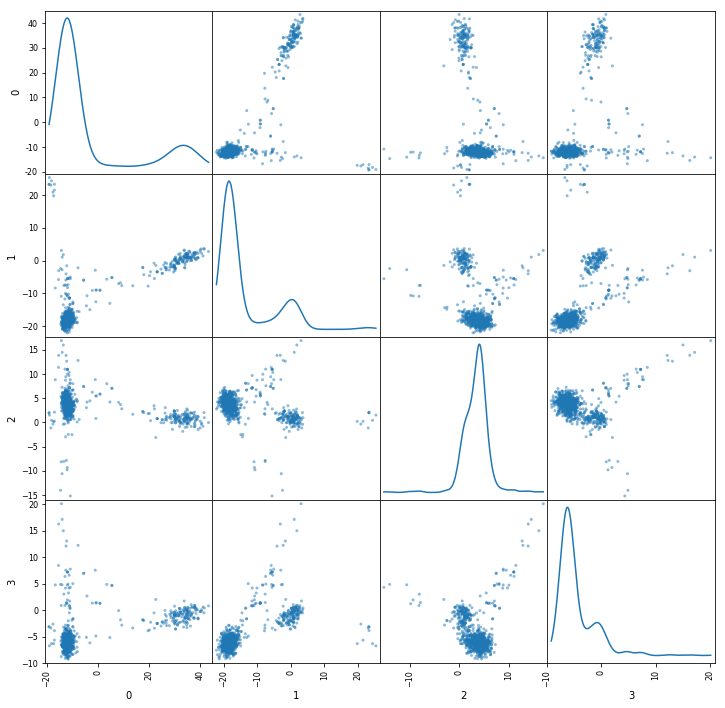

In [42]:
ax = pd.plotting.scatter_matrix(pcs_called_df.loc[:, :3], figsize=(12,12), diagonal='kde')
# for i, (ax_min, ax_max) in enumerate(lims):
#     for j in range(len(lims)):
#         ax[i, j].set_ylim(ax_min, ax_max)
#         ax[j, i].set_xlim(ax_min, ax_max)

## do classifier

In [43]:
# get target values
ancestries = labels_df['super_pop'].values
ancestry_encoder = LabelEncoder()
ancestry_encoder.fit(list(set(ancestries)))
y = ancestry_encoder.transform(ancestries)

In [44]:
# do normalization
X = np.copy(pcs_genomes_df.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
rf_scaler = StandardScaler()
rf_scaler.fit(X_train)
X_train = rf_scaler.transform(X_train)
X_test = rf_scaler.transform(X_test)

In [46]:
X_train.shape, X_test.shape

((2003, 20), (501, 20))

In [47]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
# train accuracy and test accuracy
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.9940119760479041)

## classify samples

In [49]:
# do classification of mm samples
samples = df_called.columns[9:]
X_samples = np.copy(pcs_called_df.values)
X_samples = rf_scaler.transform(X_samples)

predictions = clf.predict(X_samples)
predictions = ancestry_encoder.inverse_transform(predictions)

sample_to_predictions = {k:v for k, v in zip(samples, predictions)}
colors = [ancestry_to_color[sample_to_predictions[s]] for s in samples]

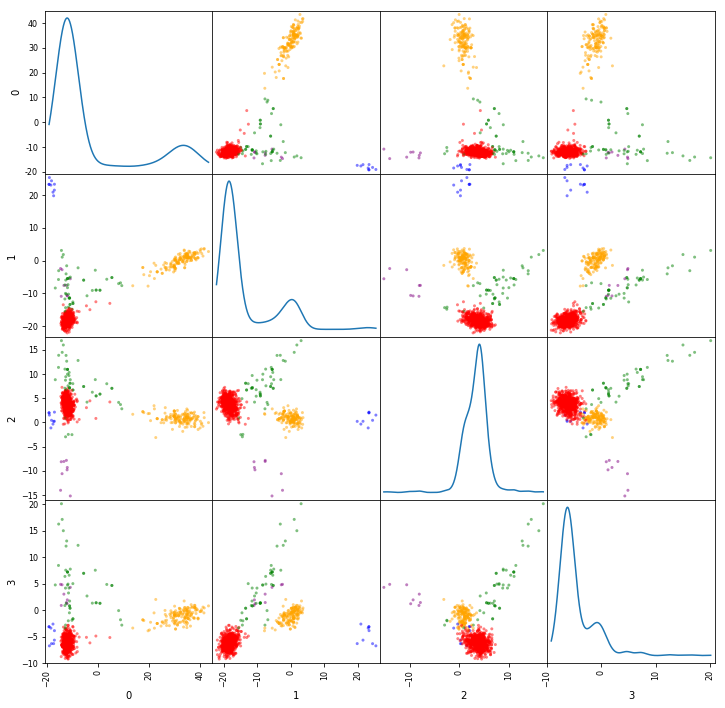

In [50]:
ax = pd.plotting.scatter_matrix(pcs_called_df.loc[:, :3], color=colors, figsize=(12,12), diagonal='kde')
# for i, (ax_min, ax_max) in enumerate(lims):
#     for j in range(len(lims)):
#         ax[i, j].set_ylim(ax_min, ax_max)
#         ax[j, i].set_xlim(ax_min, ax_max)

In [51]:
# do classification of mm 14 samples
samples_MM = df_called_MM.columns[9:]
X_samples_MM = np.copy(pcs_called_MM_df.values)
X_samples_MM = rf_scaler.transform(X_samples_MM)

predictions_MM = clf.predict(X_samples_MM)
predictions_MM = ancestry_encoder.inverse_transform(predictions_MM)

sample_to_predictions_MM = {k:v for k, v in zip(samples_MM, predictions_MM)}
colors = [ancestry_to_color[sample_to_predictions_MM[s]] for s in samples_MM]

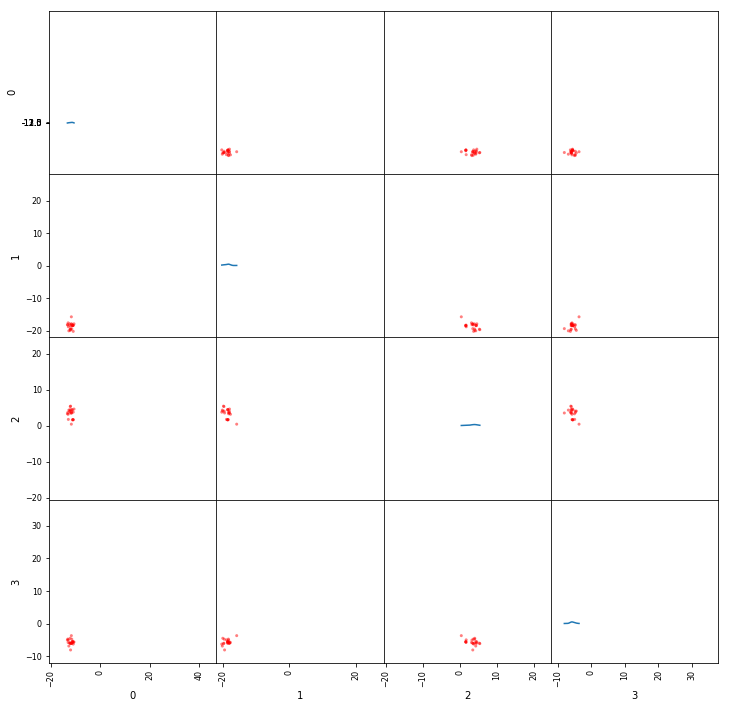

In [52]:
ax = pd.plotting.scatter_matrix(pcs_called_MM_df.loc[:, :3], color=colors, figsize=(12,12), diagonal='kde')
for i, (ax_min, ax_max) in enumerate(lims):
    for j in range(len(lims)):
        ax[i, j].set_ylim(ax_min, ax_max)
        ax[j, i].set_xlim(ax_min, ax_max)

In [53]:
sample_prediction_tups = [(s, p) for s, p in sample_to_predictions.items()]
sample_prediction_tups = sorted(sample_prediction_tups, key=lambda x: x[0])
samps, preds = zip(*sample_prediction_tups)
prediction_df = pd.DataFrame.from_dict({
    'sample': samps,
    'predicted_ancestry': preds
})
prediction_df.head()

,sample,predicted_ancestry
0,MMRF_1016_1,EUR
1,MMRF_1020_3,EUR
2,MMRF_1021_1,EUR
3,MMRF_1024_2,EUR
4,MMRF_1029_1,EUR


In [54]:
prediction_df.to_csv(PREDICTIONS_FP, sep='\t', index=False)

## nice plot

In [55]:
## deduplicate samples
def deduplicate_col(df, col_name):
    to_drop = []
    prev = None
    for i, row in df.iterrows():
        if prev is not None and prev == row[col_name]:
            to_drop.append(i)

        prev = row[col_name]
    
    return df.drop(to_drop) 

def pad_ax_limits(limits, padding=.05):
    return [(a - abs(padding * (b - a)), b + abs(padding * (b - a))) for a, b in limits]

In [56]:
def scatterplot(df, x_dim, y_dim, category, colormap, shapemap=None, figsize=(10, 5), size=5, alpha=.7, fontsize=10,
               legend_props={}, save=None, title='', xlim=None, ylim=None):
    
 
    fig, ax = plt.subplots(figsize=figsize)
    
    for cat in sorted(list(set(df[category]))):
        mini_df = df[df[category]==cat]
        x = mini_df[x_dim]
        y = mini_df[y_dim]
        
        plt.scatter(x, y, c=colormap[cat], label=cat, s=size, alpha=alpha)            

    ax.set_title(title).set_fontsize(fontsize)
    ax.set_xlabel(x_dim).set_fontsize(fontsize)
    ax.set_ylabel(y_dim).set_fontsize(fontsize)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.legend(prop=legend_props)
    
    if save is None:
        plt.show()
    else:
        plt.savefig(save, dpi=1200)
        
def scatterplot_mult_shapes(df, x_dim, y_dim, category, kwargs_col, colormap, shapemap=None, figsize=(10, 5), size=5, alpha=.7, fontsize=10,
               legend_props={}, save=None, title='', xlim=None, ylim=None):
    
 
    fig, ax = plt.subplots(figsize=figsize)
    
    for cat in sorted(list(set(df[category]))):
        for kwarg_value in sorted(list(set(df[kwargs_col]))):
            mini_df = df[df[category]==cat]
            mini_df = mini_df[mini_df[kwargs_col] == kwarg_value]
            x = mini_df[x_dim]
            y = mini_df[y_dim]
            
            kws = kwarg_value.split('|')
            d = {x.split(':')[0]:x.split(':')[1] for x in kws}

            for k,v in d.items():
                if '.' in v:
                    try:
                        d[k] = float(v)
                    except ValueError:
                        pass
                elif v.isdigit():
                    d[k] = int(v)
            print(d)

            plt.scatter(x, y, c=colormap[cat], label=cat, **d)            

    ax.set_title(title).set_fontsize(fontsize)
    ax.set_xlabel(x_dim).set_fontsize(fontsize)
    ax.set_ylabel(y_dim).set_fontsize(fontsize)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.legend(prop=legend_props)
    
    if save is None:
        plt.show()
    else:
        plt.savefig(save, dpi=1200)

In [57]:
padded_lims = pad_ax_limits(lims, padding=.1)
padded_lims

[(-27.63751351917265, 53.551505063563184),
 (-26.93943754162624, 33.29734952696194),
 (-25.108219659963133, 29.195807215202795),
 (-17.029323013359864, 42.89056209839783)]

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


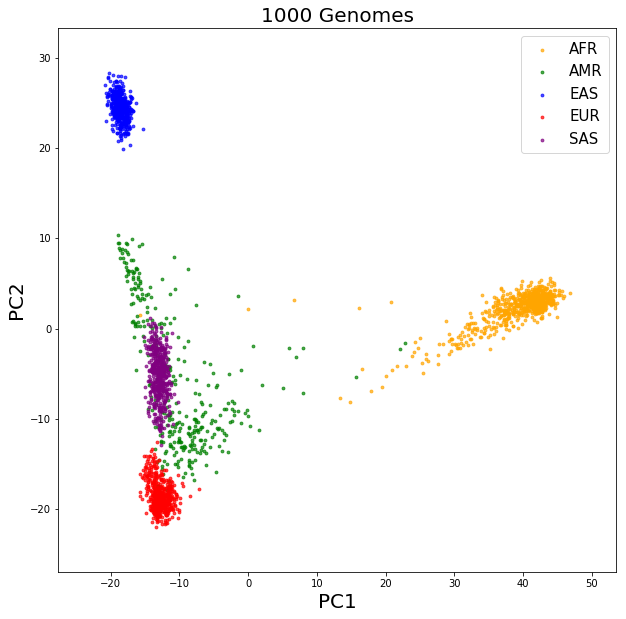

In [58]:
genome_plot_df = pcs_genomes_df[[0, 1]]
genome_plot_df.columns = ['PC1', 'PC2']
genome_plot_df['Ancestry'] = list(labels_df['super_pop'])
scatterplot(genome_plot_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
           legend_props={'size': 15}, title='1000 Genomes', xlim=padded_lims[0], ylim=padded_lims[1])

In [59]:
self_reported_df = pd.read_csv(SELF_REPORTED_FP, sep='\t')
self_reported_df.head()

,PUBLIC_ID,race
0,MMRF_1007,1
1,MMRF_1011,1
2,MMRF_1013,1
3,MMRF_1014,1
4,MMRF_1016,1


In [60]:
self_reported_df.columns = ['sample', 'self_reported_ancestry']
self_reported_df = self_reported_df.replace(1, 'EUR')
self_reported_df = self_reported_df.replace(2, 'AFR')
self_reported_df = self_reported_df.replace(3, 'OTHER')
self_reported_df.head()

,sample,self_reported_ancestry
0,MMRF_1007,EUR
1,MMRF_1011,EUR
2,MMRF_1013,EUR
3,MMRF_1014,EUR
4,MMRF_1016,EUR


In [61]:
called_plot_df = pcs_called_df[[0, 1]]
called_plot_df.columns = ['PC1', 'PC2']
called_plot_df['Ancestry'] = list(predictions)

samples_called_shortened = [s[:-2] for s in samples_called]
called_plot_df['sample'] = samples_called_shortened
called_plot_df['sample_id'] = samples_called

called_plot_df = called_plot_df.merge(self_reported_df, on='sample')

deduplicated_called_plot_df = deduplicate_col(called_plot_df, 'sample')

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [62]:
called_plot_df.shape, deduplicated_called_plot_df.shape

((938, 6), (856, 6))

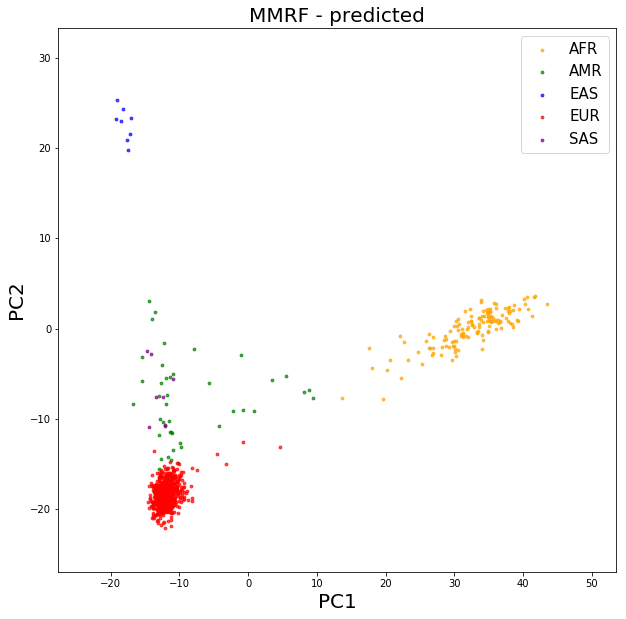

In [63]:

scatterplot(deduplicated_called_plot_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
           legend_props={'size': 15}, title='MMRF - predicted', alpha=.7, xlim=padded_lims[0], ylim=padded_lims[1])

In [64]:
Counter(deduplicated_called_plot_df['Ancestry'])

Counter({'EUR': 661, 'SAS': 8, 'AMR': 42, 'AFR': 137, 'EAS': 8})

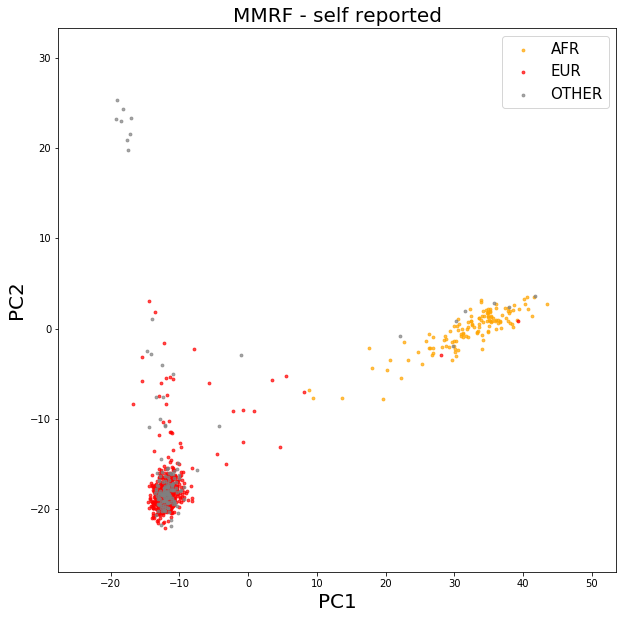

In [65]:
self_reported_ancestry_to_color = {
    'EUR': ancestry_to_color['EUR'],
    'AFR': ancestry_to_color['AFR'],
    'OTHER': 'gray'
}


scatterplot(deduplicated_called_plot_df, 'PC1', 'PC2', 'self_reported_ancestry', self_reported_ancestry_to_color, size=8, figsize=(10, 10),
            fontsize=20, legend_props={'size': 15}, title='MMRF - self reported', xlim=padded_lims[0], ylim=padded_lims[1])

In [66]:
Counter(deduplicated_called_plot_df['self_reported_ancestry'])

Counter({'EUR': 572, 'OTHER': 153, 'AFR': 131})

In [67]:
MM_paper_samples = pd.read_csv(MM_PAPER_SAMPLES_FP, sep='\t', header=None)
MM_paper_samples = list(MM_paper_samples[0])
# MM_paper_samples

In [68]:
MMRF_paper_df = deduplicated_called_plot_df[called_plot_df['sample'].isin(MM_paper_samples)]
MMRF_paper_df.shape

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(31, 6)

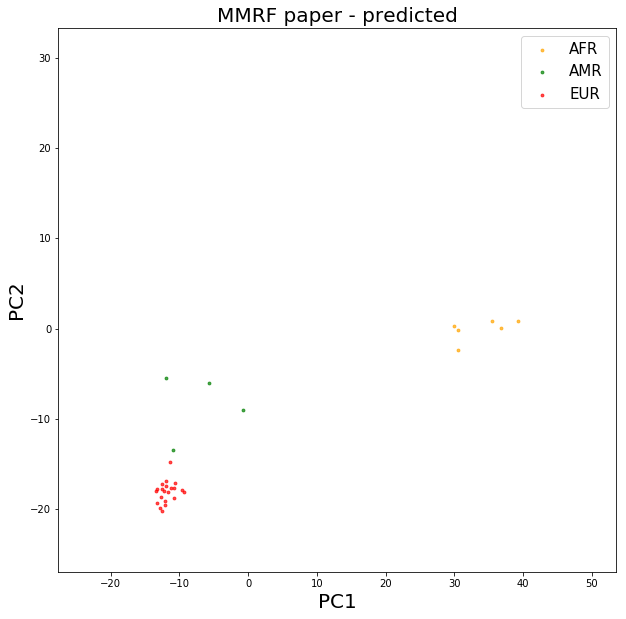

In [69]:
scatterplot(MMRF_paper_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10),
            fontsize=20, legend_props={'size': 15}, title='MMRF paper - predicted', xlim=padded_lims[0], ylim=padded_lims[1])

In [70]:
Counter(MMRF_paper_df['Ancestry'])

Counter({'EUR': 21, 'AMR': 4, 'AFR': 6})

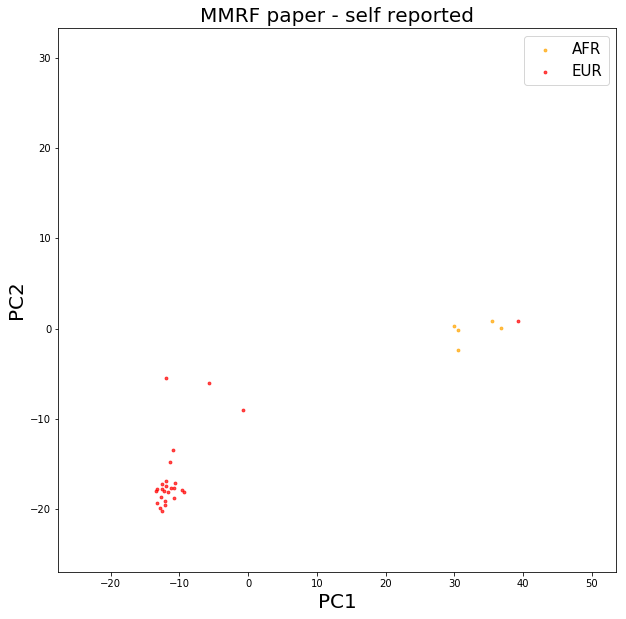

In [71]:
scatterplot(MMRF_paper_df, 'PC1', 'PC2', 'self_reported_ancestry', ancestry_to_color, size=8, figsize=(10, 10),
            fontsize=20, legend_props={'size': 15}, title='MMRF paper - self reported', xlim=padded_lims[0], ylim=padded_lims[1])

In [72]:
called_plot_MM_df = pcs_called_MM_df[[0, 1]]
called_plot_MM_df.columns = ['PC1', 'PC2']
called_plot_MM_df['Ancestry'] = list(predictions_MM)

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:

# scatterplot(called_plot_MM_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
#            legend_props={'size': 15}, title='MM - predicted', alpha=.7, xlim=padded_lims[0], ylim=padded_lims[1])

In [81]:
samples_called_MM_shortened = [s.split('.')[0] for s in samples_called_MM]
called_plot_MM_df['sample'] = samples_called_MM_shortened
called_plot_MM_df['sample_id'] = samples_called_MM

/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/gscmnt/gc2508/dinglab/estorrs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


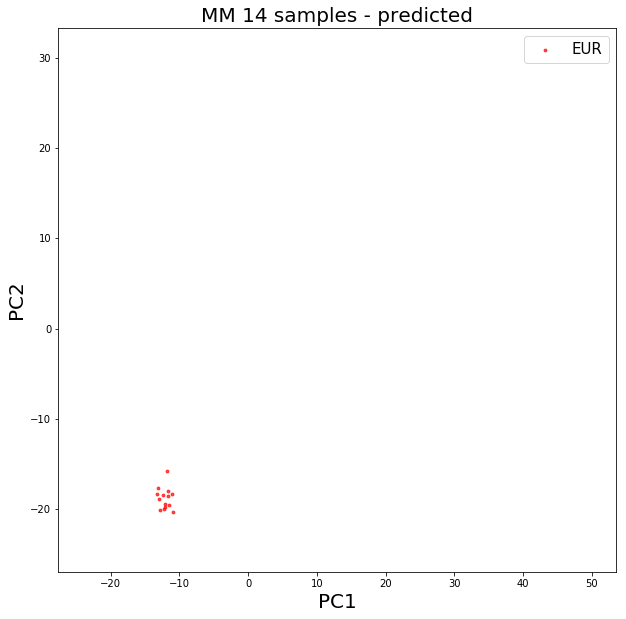

In [82]:
scatterplot(deduplicate_col(called_plot_MM_df, 'sample'), 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
           legend_props={'size': 15}, title='MM 14 samples - predicted', alpha=.7, xlim=padded_lims[0], ylim=padded_lims[1])

In [83]:
called_plot_MM_df.head()

,PC1,PC2,Ancestry,sample,sample_id
0,-11.585795,-19.530658,EUR,25183,25183.Relapse.grch37
1,-11.679977,-18.494596,EUR,27522,27522.Pre-Treatment.grch37
2,-10.695197,-17.947029,EUR,27522,27522.Relapse-1.grch37
3,-11.332935,-18.398449,EUR,27522,27522.Remission.grch37
4,-13.212235,-18.269517,EUR,37692,37692.Pre-Treatment.grch37


In [84]:
df_1 = deduplicate_col(called_plot_MM_df, 'sample')
df_2 = MMRF_paper_df
df_3 = deduplicated_called_plot_df

pc1 = list(df_1['PC1']) + list(df_2['PC1']) + list(df_3['PC1'])
pc2 = list(df_1['PC2']) + list(df_2['PC2']) + list(df_3['PC2'])

ancestry = list(df_1['Ancestry']) + list(df_2['Ancestry']) + list(df_3['Ancestry'])
kwarg_strs = (['marker:v|s:150|alpha:.7'] * df_1.shape[0]) + (['marker:+|s:100|alpha:.7'] * df_2.shape[0]) + (['marker:.|s:20|alpha:.3'] * df_3.shape[0])
plt_df = pd.DataFrame.from_dict({
    'PC1': pc1,
    'PC2': pc2,
    'Ancestry': ancestry,
    'kwargs': kwarg_strs
})

In [85]:
df_1.shape, df_2.shape, df_3.shape

((14, 5), (31, 6), (856, 6))

{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}


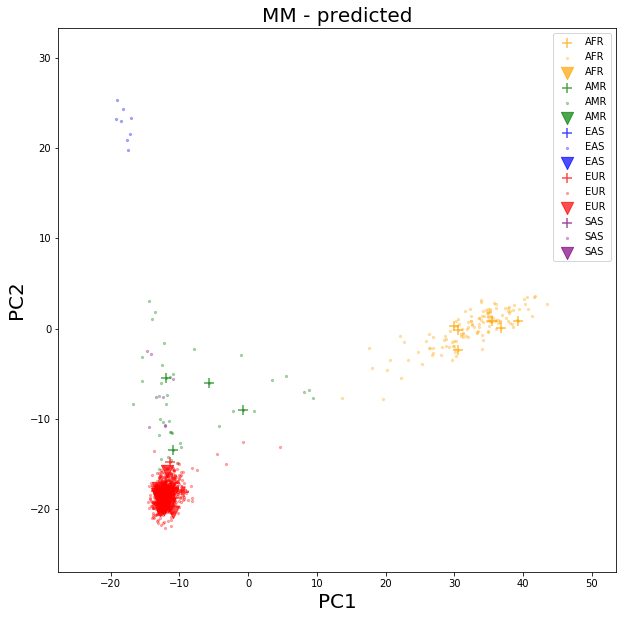

In [93]:
scatterplot_mult_shapes(plt_df, 'PC1', 'PC2', 'Ancestry', 'kwargs', ancestry_to_color, size=50, figsize=(10, 10),
                        fontsize=20, legend_props={'size': 10}, title='MM - predicted', alpha=.7,
                        xlim=padded_lims[0], ylim=padded_lims[1],
                        save='/gscmnt/gc2737/ding/estorrs/ancestry/figures/combined.pdf')

In [87]:
lims

[(-20.87176197061133, 46.785753515001865),
 (-21.91970528591056, 28.277617271246257),
 (-20.58288408703264, 24.6704716422723),
 (-12.035999254046724, 37.89723833908469)]

In [91]:
!pwd

/gscuser/estorrs/dance/notebooks


{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}
{'marker': '+', 's': 100, 'alpha': 0.7}
{'marker': '.', 's': 20, 'alpha': 0.3}
{'marker': 'v', 's': 150, 'alpha': 0.7}


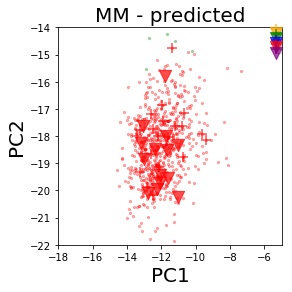

In [92]:
scatterplot_mult_shapes(plt_df, 'PC1', 'PC2', 'Ancestry', 'kwargs', ancestry_to_color, size=50, figsize=(4, 4),
                        fontsize=20, legend_props={'size': 1}, title='MM - predicted', alpha=.7, xlim=[-18, -5],
                        ylim=[-22, -14], save='/gscmnt/gc2737/ding/estorrs/ancestry/figures/zoomed_eur.pdf')

# plt.savefig('zoomed_eur.pdf', dpi=1000)